# **Task-1**

### Information about this notebook

##### 1. Optimization has been done starting from circuit with 1 layer upto circuit with 15 layers.
##### 2. Finally the minimum distance in the circuit has been plotted as a function of no. of layers used in that circuit.
##### 3. Also the no. of iteration used is also plotted as a function of no. of layers.

### Note - In this notebook, all the circuits has been put together by looping over the no. of layers, and finally overall plots has been shown (no seperate plot for each circuit has been shown here). 
### In the another notebook, seperate cells has been dedicated for each circuit and finally in the last part, information like minimum distance from all circuits has been put together and plotted.

## The block below executes to do all the necessary imports

In [11]:
import numpy as np
import pennylane as qml

from pennylane import expval, var
from matplotlib import pyplot as plt


## initialize_theta()
#### Arguments - only a single arg, no. of layers in the circuit
#### It randomly generates a numpy array having (layers X 2) no. of rows and 4 columns
#### Each element in the np array is a theta value for a parameterized gate ranging from (0,2pi)
#### Return - numpy array

In [21]:
pi = np.pi
def initialize_theta(layers):
    row = layers*2
    column = 4
    theta = np.random.uniform(low=0, high=2*pi, size=(row, column))
    
    
    return theta

## initialize_random_phi()
#### Arguments - no args is passed
#### as the phi is used as reference with the circuit output, it returns an numpy array having same dimension of statevector returned by the circuit
#### Since the circuit has 4 wires, statevector will have 2^4 or 16 elements

In [22]:
# This function returns a random valued numpy array phi, with respect to which distance of the quantum circuit will be calculated
# dimension of phi will be same as the dimension of np array returned by simulate_circuit() 
def initialize_random_phi():
    phi = np.random.randn(16,)
    return phi

## simulate_circuit()
#### Arguments - the numpy array containing all the parameters for each gate
#### Creates a object of device class using required attributes
#### calls the circuit() function defined inside it to generate the specific circuit using paramaters passed
#### Return - returns the output statevector of the simulated circuit using dev.state

In [23]:
def simulate_circuit(theta):
    dev = qml.device("default.qubit", wires=4)

    @qml.qnode(dev)
    def circuit(theta):
    #This circuit function genrates the quantum circuit. It takes only the parameters theta as the argument
    
        #The no. of layers has not to be passed explicitely, as it is calculated from dimension of theta here
        layers = theta.shape[0] // 2

        for i in range(layers):

            # yellow block
            for j in range(4): #This loops over all four qubits and apply RX gate with proper param extracted from theta
                qml.RX(theta[2*i][j], wires=j)

            # Green block
            for j in range(4): #THis loops over all 4 qubits and apply RZ gate with proper param extracted from theta
                qml.RZ(theta[(2*i)+1][j], wires=j)

            for control in range(3): # Double qubit CZ gates has been applied here
                for target in range(control+1, 4):
                    qml.CZ(wires=[control, target])

        # this pauliZ measured values are not used but has to be returned because circuit() function can't return None
        return qml.expval(qml.PauliZ(wires=0)),  qml.expval(qml.PauliZ(wires=1)), qml.expval(qml.PauliZ(wires=2)), qml.expval(qml.PauliZ(wires=3))
       
    circuit(theta)
    
    #returns the 2^4 = 16 dimensioned output statevector of the simulated circuit
    return dev.state

## calc_distance()
#### Arguments - takes only the numpy array containing parameters for all parameterized gates in the circuit
#### it calls the function simulate_circuit(), which returns the statevector psi_of_theta
#### now it calculates the difference of psi_of_theta and phi (phi has been initialized globally and used the same for all the circuit in this notebook)
#### Finally the sum of square of mod of all 16 complex numbers has been calculated 
#### Return - a single float value which is calculated, mentioned above

In [24]:
# This function takes the theta, calls the simulate_circuit() func and calculates the distance of vector returned 
# by the simulate_circuit() with respect to global variable psi
def calc_distance(theta):
    
    psi_of_theta = simulate_circuit(theta) 
    diff = psi_of_theta - phi #phi is the global one here, used for all the layers
    mod_sqr = diff.real**2 + diff.imag**2
    distance = np.sum(mod_sqr) #calculates the sum of squares of mod of difference between corresponding elements of psi and phi
    
    # returns the distance (as mentioned in the problem statement)
    return distance

## optimize()
#### Arguments - np array of all parameters, maximum no. of iteration used and two optional boolean parameters- print_distance, plot_distance
#### *Imp. point to note - although iteration is passed as a parameter in the function, but there is a callback used below, which terminates the optimization when three consecutive calculated distance is same(upto 2 decimal places) considering the fact that minimum distance has been achieved*
#### the RotosolveOptimizer available in pennylane has been used here to optimize the parameters to get the minimum distance for each circuit
#### while calling the function, if print_distance is set as True, it prints the distance calculated in each iteration
#### if the plot_distance is also set True, it will plot the calculated distance vs iteration after the optimization of a specific circuit is completed
#### Returns - a dict containing minimum_distance calculated after the optimization, no. of iteration used and optimized parameters value

In [25]:
# this takes params of the circuit, iteratioin as necessary arguments
# also two optional args to print and plot the distance for each layer count
def optimize(theta, iterations, print_distance=False, plot_distance=False):
    
    
    distance_hist = [] #keeps track of distance after each iterations
    
    optimizer = qml.optimize.RotosolveOptimizer() 
    
    # callback: this flag is initialized to keep track of repeating distances, which is further used to terminate the iteration
    # when optimization is completed approx
    flag = 0
    
    print("Optimizing", end='')
    
    for i in range(iterations): 
        theta = optimizer.step(calc_distance, theta)
        distance = calc_distance(theta) #calls the calc_distance() to calculate distance of the circuit
        print('.', end='')
        
        # this code chunk is used to compare current distance with the previous one to check repetations
        if(len(distance_hist)>0):
            if(round(distance_hist[-1],2)==round(distance,2)): #here upto 2 decimal places round off has been done
                flag += 1
            else:
                flag = 0
        distance_hist.append(distance)
        if(print_distance):
            print("Iteration=> "+str(i)+", distance=> "+str(distance))
        
        # Whenever flag becomes 3, means 3 times same distance has been calculated, we can assume the params to be
        # optimized and can terminate the optimization
        if(flag == 3):
            break
    
    print('\nOptimization Completed')
        
        
    if(plot_distance):
        plt.style.use("seaborn")
        plt.plot(distance_hist, "b", label="Optimization")
        plt.ylabel("Distance value")
        plt.xlabel("Optimization steps")
        plt.legend()
        plt.show()
    
    #returns the final_cost, maximum iteration used and optimized parameter values
    cache = {"min_distance": distance_hist[-1],
             "iter": i+1,
             "optimized_theta": theta}
    
    return cache

## Three lists initialized below will store various data returned by each circuit simulated.

## Finally looped over all the circuit starting from 1 to max_layers=15, initialized random parameter values, calls the optimize function to optimize the parameters to get minimum value of distance
## finally prints some information about each circuit after optimization - minimum distance and no. of iteration used.

In [26]:
# main function

phi = initialize_random_phi() #initialized a vector phi as a referenc of cost for the whole process
iter_list = [] # it will store no. of iterations used for each circuit
min_distance_list = [] # it will store the minimum distance of circuit for each circuit
optimized_theta_list = [] #similarly stores the optimized params for each circuit

max_layers = 15 # so we will start from a single layer circuit and go upto 15 layers circuit


for layers in range(1,max_layers+1):
    print("\n\n Layer count in Circuit => "+str(layers))
    theta = initialize_theta(layers) #initializes random theta values which will be optimized further
    
    # calls the optimize() function which will first create a circuit with the passed theta values 
    # then optimize the parameters using RotosolveOptimizer() algorithm and finally returns min_distance, iteration used and optimized params
    # although the iteration is initialized as 50, if it fulfils the callback condition, it will be terminated earlier
    cache = optimize(theta, 50) 
    
    iter_list.append(cache['iter'])
    min_distance_list.append(cache['min_distance'])
    
    print("\n Iteration used => "+str(cache['iter']))
    print(" Minimum distance => "+str(cache['min_distance']))
    print("\n_______________________________________")
    print("_______________________________________")
    





 Layer count in Circuit => 1
Optimizing.......
Optimization Completed

 Iteration used => 7
 Minimum distance => 16.351710577844003

_______________________________________
_______________________________________


 Layer count in Circuit => 2
Optimizing............................................
Optimization Completed

 Iteration used => 44
 Minimum distance => 14.507929767993415

_______________________________________
_______________________________________


 Layer count in Circuit => 3
Optimizing..................
Optimization Completed

 Iteration used => 18
 Minimum distance => 12.716285387323635

_______________________________________
_______________________________________


 Layer count in Circuit => 4
Optimizing.......................
Optimization Completed

 Iteration used => 23
 Minimum distance => 12.294125630967084

_______________________________________
_______________________________________


 Layer count in Circuit => 5
Optimizing...................
Optimization

# Final Plot 1 - Plot of Minimum distance as a function of no. of layers used in the circuit

# Points to observe - 
## 1. In the plot below, starting from the circuit having 6 layers, upto the last i.e. 15 layers, the minimum distance has become very close and from layers 10 it became same approximately.
## 2. Also from each specific circuit to the next circuit, minimum distance has been decreased or remained same.


# Plot 2 - Plot of iteration as a function of no. of layers used in the circuit

## Although we have specified the no. of iterations while calling the optimize() function, but due the callback, earlystopping has occured in almost all cases. 
## The no. of iteration used has also been placed as a function of layers in the circuit.

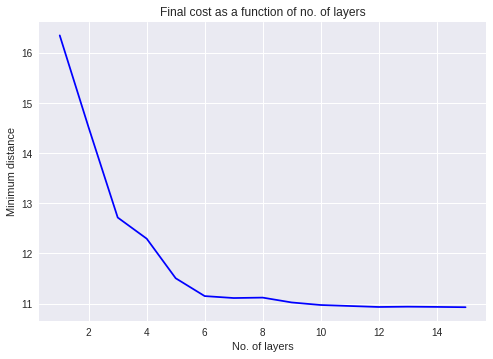

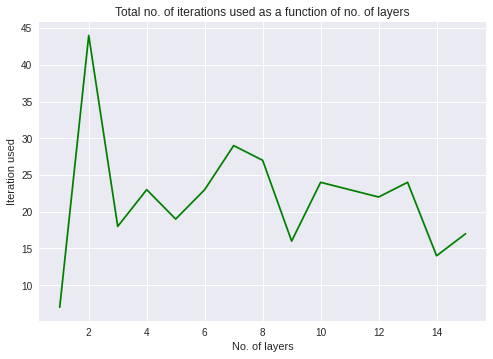

In [27]:
# plots minimum distance as a function of no. of layers used in the circuit
plt.style.use("seaborn")
plt.plot(np.arange(1,max_layers+1),min_distance_list, "b")
plt.ylabel("Minimum distance")
plt.xlabel("No. of layers")
plt.title("Final cost as a function of no. of layers")
plt.show()

# plots the no. of iterations used as a function of no. of layers in the specific circuit
plt.plot(np.arange(1,max_layers+1),iter_list, "g")
plt.ylabel("Iteration used")
plt.xlabel("No. of layers")
plt.title("Total no. of iterations used as a function of no. of layers")
plt.show()